In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from pyCascade.probeReadWrite import read_probes_file_switch
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [2]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [12]:
run = 46
probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

In [13]:
qoisOutputed = ["comp(u,0)", "comp(u,1)", "comp(u,2)", "p", "T", "D", "S"]
probesV = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "VOLUMETRIC_PROBES", flux_quants = qoisOutputed, file_type = "parquet")

processing data took 59 seconds
processing data took 66 seconds
processing data took 60 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


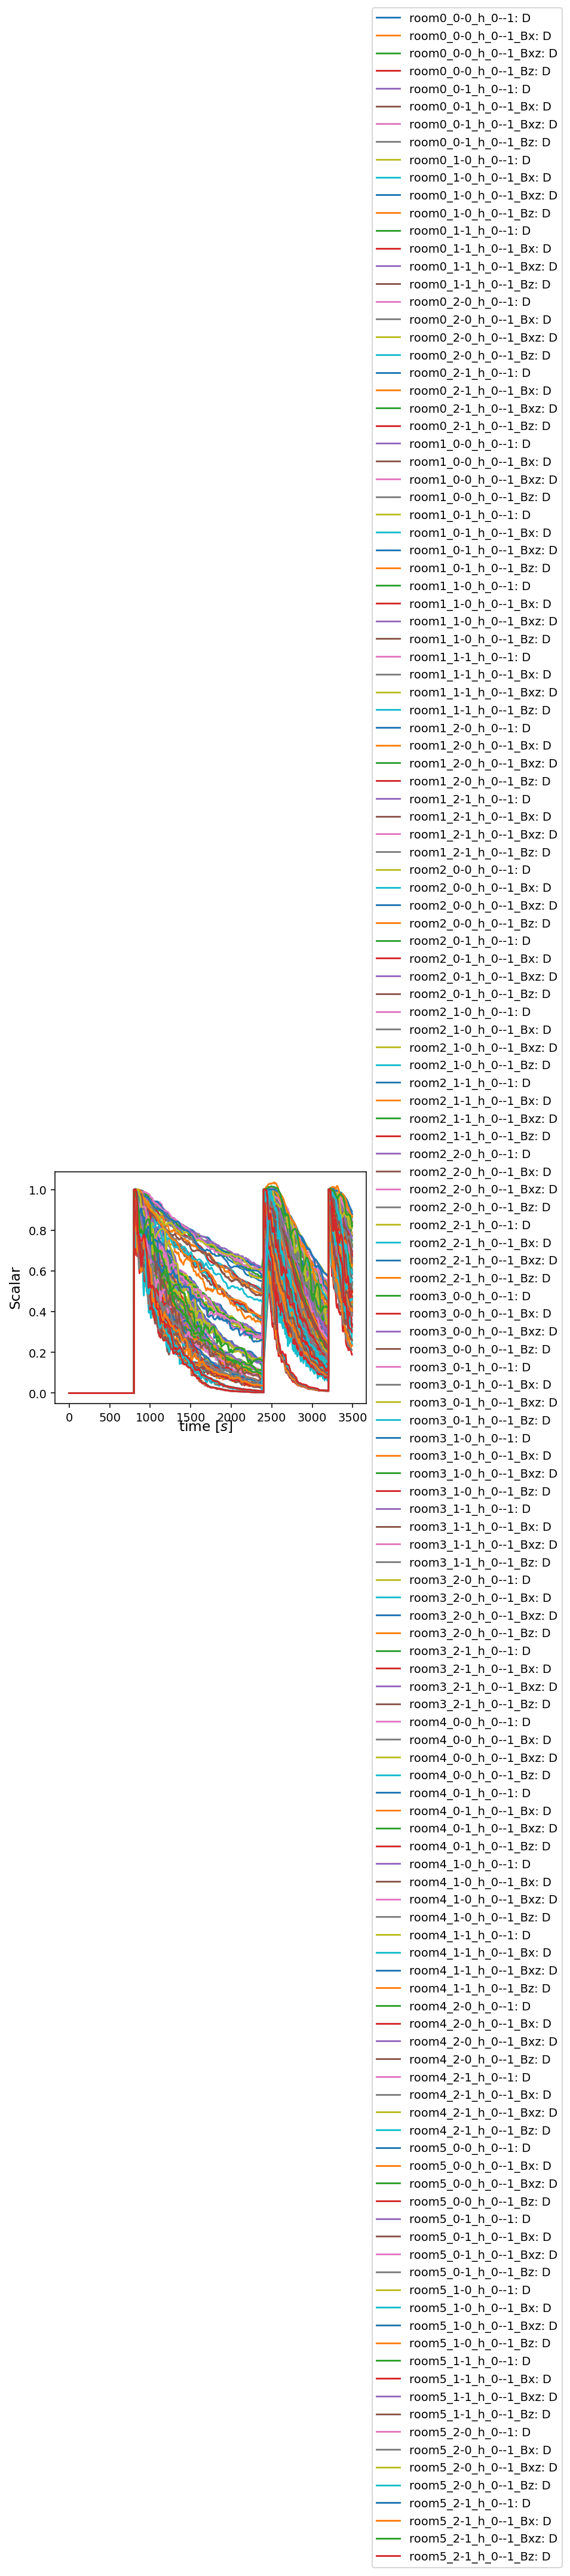

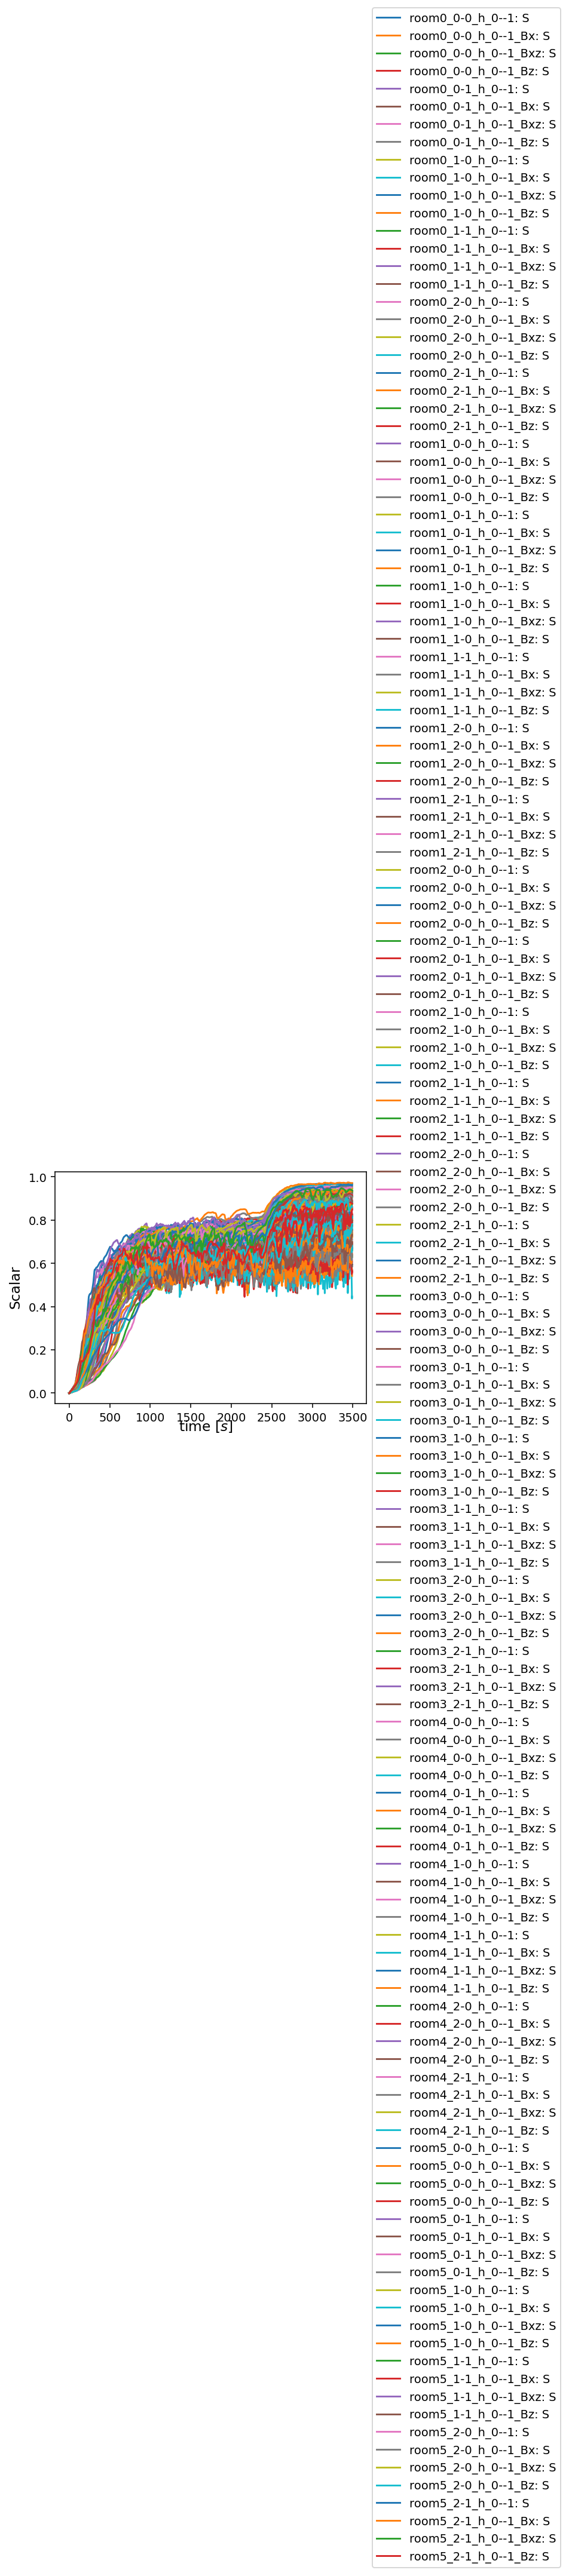

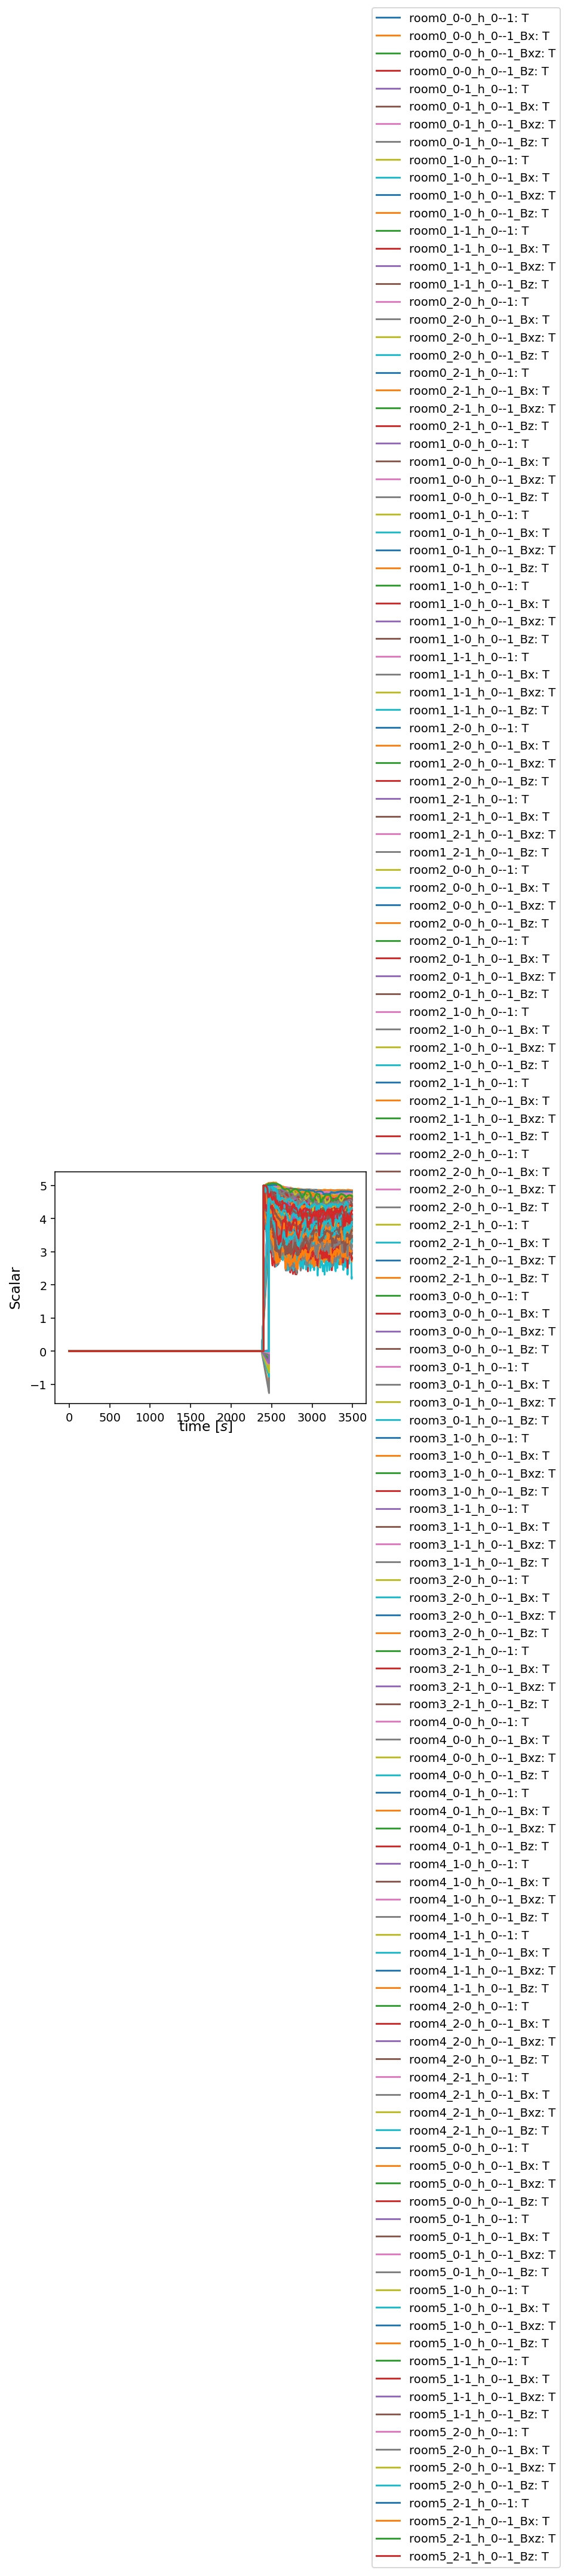

In [16]:
(fig, ax) = probesV.time_plots(
    names = [name for name in  probesV.probe_names if "_h_0--1" in name], 
    steps = probesV.probe_steps[0:-1:1],
    quants = ["D"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Scalar',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probesV.probe_times,
        'plot every': 1000
        },
    parrallel=True
    )

(fig, ax) = probesV.time_plots(
    names = [name for name in  probesV.probe_names if "_h_0--1" in name], 
    steps = probesV.probe_steps[0:-1:1],
    quants = ["S"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Scalar',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probesV.probe_times,
        'plot every': 1000
        },
    parrallel=True
    )

(fig, ax) = probesV.time_plots(
    names = [name for name in  probesV.probe_names if "_h_0--1" in name], 
    steps = probesV.probe_steps[0:-1:1],
    quants = ["T"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Scalar',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probesV.probe_times,
        'plot every': 1000
        },
    parrallel=True
    )

In [27]:
roomFluxMean = pd.read_csv(f"{oak_probes_dir}/../roomFluxMean-40000to120000.csv", index_col=0)


# Function to extract components from the string
def parseRoomFluxIndex(string):
    parts = string.split('_')
    parts = [p for p in parts if p != 'h']
    prefix = parts[0]  # roomCeil or roomFloor
    room = parts[1]  # 0-0, 2-1, etc.
    house = parts[2]  # h_0--2, h_0-2, etc.
    block = parts[3] if len(parts) > 3 else ''  # Bx, Bz, Bxz, or ''

    # Extract flux_type (ceil or floor) from prefix
    flux_type = 'ceil' if 'Ceil' in prefix else 'floor'

    return pd.Series([flux_type, room, house, block])

# Apply the parsing function to the dataframe and assign column names
roomFluxMean[['fluxType', 'roomType', 'houseType', 'blockType']] = roomFluxMean.index.to_series().apply(parseRoomFluxIndex)
roomFluxMean = roomFluxMean[~roomFluxMean['roomType'].isin(['0-1', '2-1'])]

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


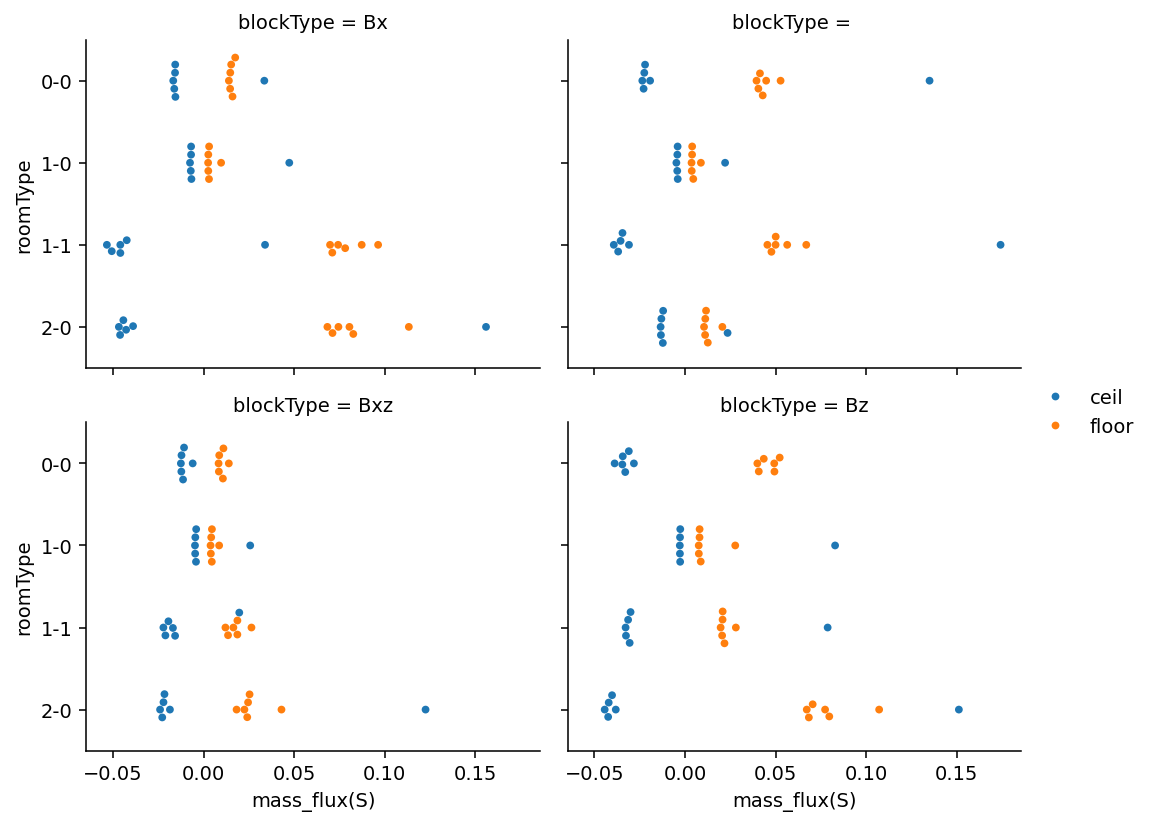

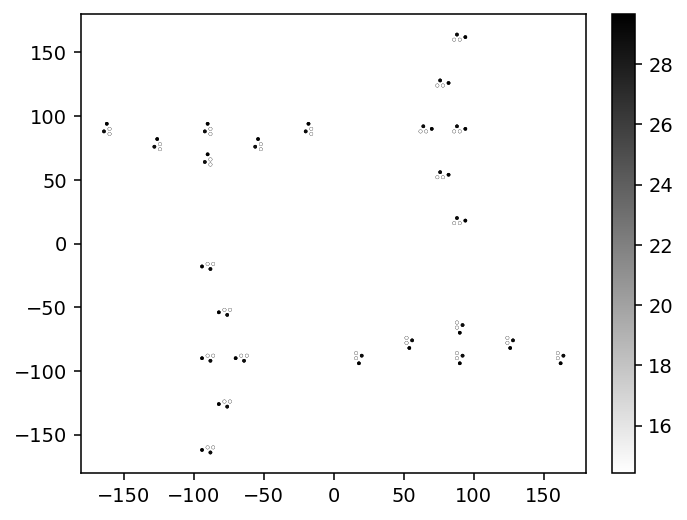

In [29]:

g = sns.FacetGrid(roomFluxMean, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "mass_flux(S)", "roomType", "fluxType", palette = "tab10", size = 4)
g.add_legend()

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomFluxMean['x'], roomFluxMean['z'], s=4*im_scaling, c=roomFluxMean["area"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)

In [6]:
# probes = probePost.Probes(probes_dir, directory_parquet=oak_probes_dir, file_type = "csv")
# probes.to_parquet(overwrite=True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "parquet")

nameKey = read_probes_file_switch(f"{probes_dir}/../locations/nameKey_extraProbe.txt")
nameKey = nameKey.compute()


extraProbe = nameKey.copy()
extraProbe = pd.concat([extraProbe, probes.locations["extraProbe"]], axis = "columns")
for qoi in ["comp(u_avg,0)", "comp(u_avg,1)", "comp(u_avg,2)"]:
    df = probePost.ddf_to_pdf(probes.data[("extraProbe", qoi)]).iloc[-1]
    df.name = qoi
    extraProbe = pd.concat([extraProbe, df], axis = "columns")
extraProbe.set_index(0, inplace=True)
extraProbe = extraProbe.rename(columns=lambda x: f"EP_{x}")
extraProbe = extraProbe.rename(index=lambda x: x.replace("extraProbe_", ''))
display(extraProbe)

del probes

KeyboardInterrupt: 

In [11]:
qoisOutputed = [
    "mass_flux",
    "mass_flux(p)",
    "mass_flux(T)",
    "mass_flux(D)",
    "mass_flux(S)",
    "sn_prod(u)",
    "sn_prod(p)",
    "sn_prod(abs(u))",
    "sn_prod(u**2)"
]
qois= ["mass_flux"]

# probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type="csv")
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



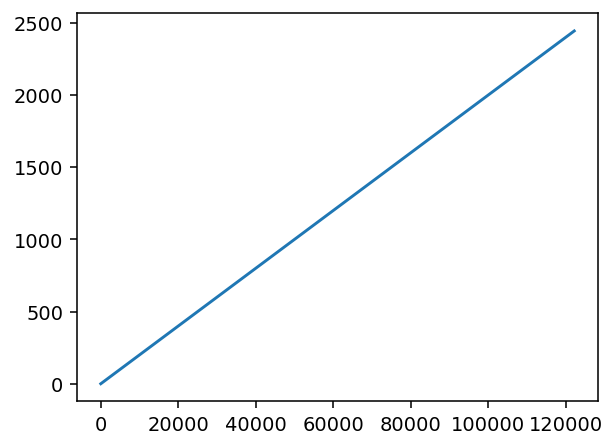

In [12]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [13]:
start = 40000# 30000
stop = 50000
by = 1

In [14]:
# plt.figure()
# foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[0])].compute()
# foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[1])].compute()
# foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
# plt.plot(foo_mass.values/foo_u.values)
# plt.ylim(0,1.225*2)


In [15]:
# plt.figure()
# N = len(foo_mass)
# f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
# plt.loglog(f, E)

## X Flow


processing data took 7 seconds


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


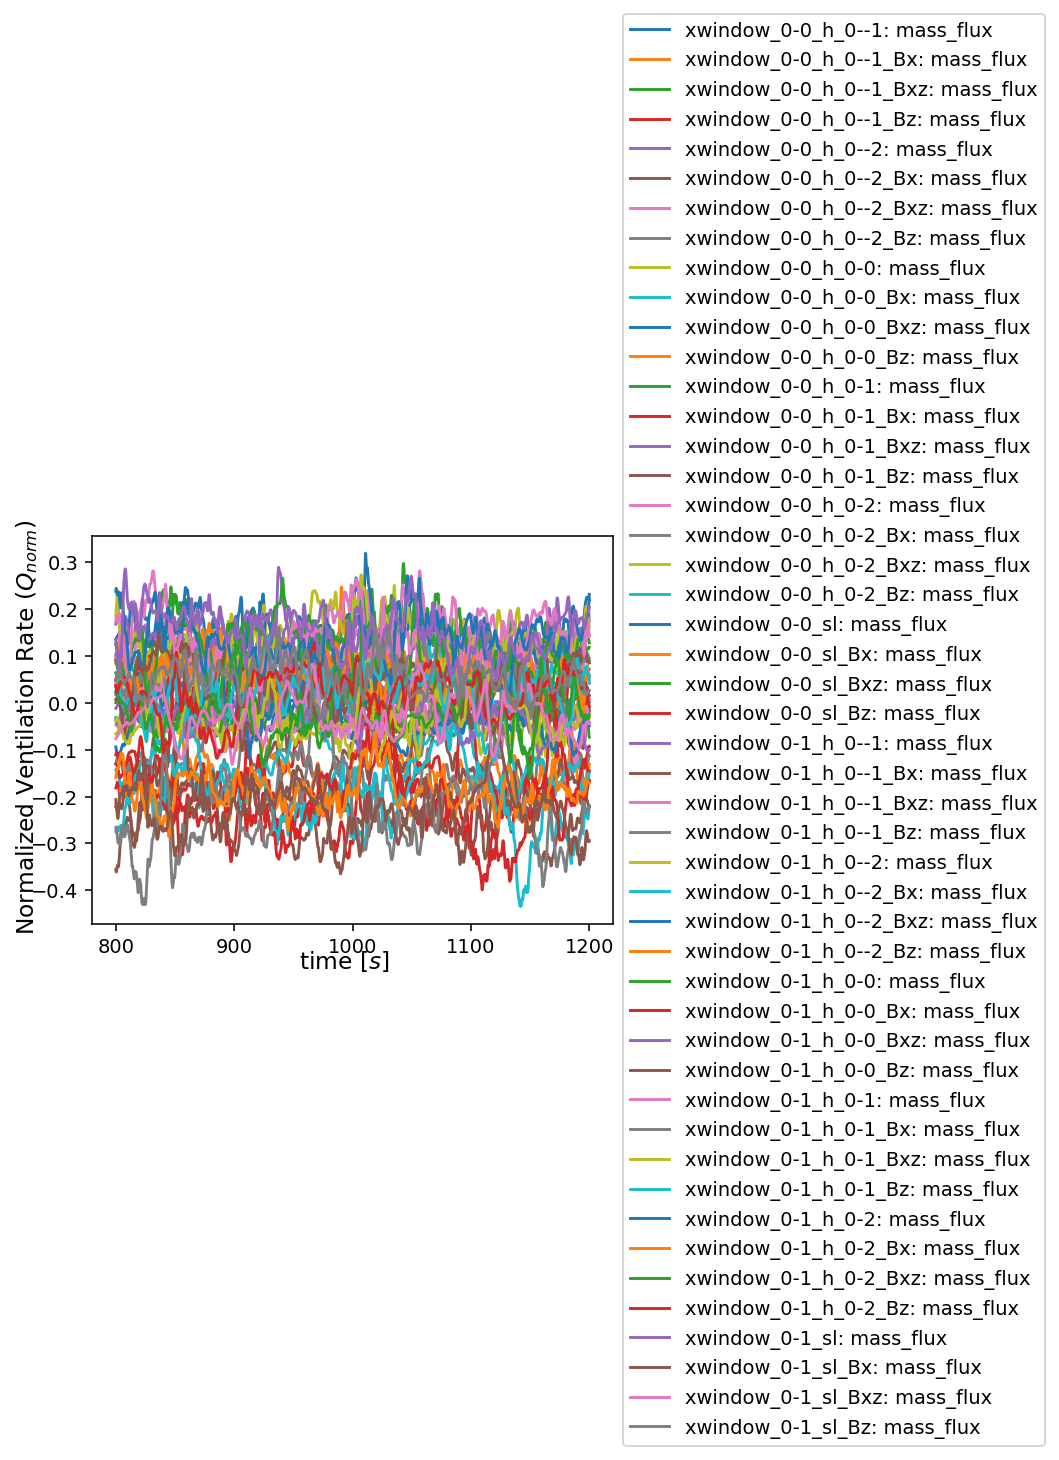

In [16]:
@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2":
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)
    return data_dict

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow_" in name], 
    steps = probes.probe_steps[start:60000:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    processing = [norm_vent, norm_norm_blocks],
    parrallel=True
    )


In [17]:

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

x_flowStats = pd.concat([x_mean, x_rms, x_net], axis = "index").T
x_flowStats.columns = ["mean", "rms", "net"]

processing data took 3 seconds
processing data took 3 seconds
processing data took 3 seconds


In [18]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows', bbox = "tight")

# x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
# x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
# x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [19]:
@utils.no_kwargs
def norm_norm_windows(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if fnmatch(name, "*window_?-1*")], -1)

@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2":
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)
    return data_dict

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "zwindow" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_windows, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
z_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm_windows, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

z_flowStats = pd.concat([z_mean, z_rms, z_net], axis = "index").T
z_flowStats.columns = ["mean", "rms", "net"]

processing data took 22 seconds
processing data took 9 seconds
processing data took 9 seconds


In [20]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows', bbox_inches = "tight")

# z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
# z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
# z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [21]:
# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "skylight" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_skylights],
#     parrallel=True
#     )

## mean statistics
y_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, flip_data],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

y_flowStats = pd.concat([y_mean, y_rms, y_net], axis = "index").T
y_flowStats.columns = ["mean", "rms", "net"]

processing data took 3 seconds
processing data took 1 seconds
processing data took 2 seconds


In [22]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

# y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
# y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
# y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')

## All Flow

In [23]:
def matchNewNamingConvention(input_str):
    # Find the position of the '-' in the string
    split_index = input_str.find('_h_')

    if split_index == -1:
        return input_str #return original if no house number
    
    n1 = int(input_str[split_index+3])
    n2 = int(input_str[split_index+5])
    
    # Modify the numbers
    new_n1 = n1 - 3
    new_n2 = n2 - 2
    
    # Format the output string with the modified numbers
    output_str = f"{new_n1}-{new_n2}"
    
    return f"{input_str[:split_index+3]}{output_str}{input_str[split_index+6:]}"



In [24]:
flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")
locations = probes.get_avg_locations()
areas = probes.areas
if category == "config2" and run < 40:
    flowStats = flowStats.rename(index=lambda x: matchNewNamingConvention(x))
    locations = locations.rename(index=lambda x: matchNewNamingConvention(x))
    areas = pd.Series(areas).rename(index=lambda x: matchNewNamingConvention(x))
flowStats = probePost.addWindowDetails(flowStats, locations, areas, extraProbe)



In [25]:

roomQois = ["mean", "net", "EP_normal", "EP_shear", "EPR_mag"]

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}
sort_order = ["blockType", "houseType", "roomType"]
roomVentilation = probePost.roomStatistics(flowStats, connectedWindows, roomQois)
roomVentilation = roomVentilation.sort_values(by = sort_order)
sort_order.append("windowType")
flowStats = flowStats.sort_values(by = sort_order)

roomVentilation["nWindows"] = roomVentilation["mean"].apply(lambda l: len(l))
roomVentilation["contResid"] = roomVentilation["mean"].apply(lambda l: sum(l))
for qoi in ["mean", "net"]:
    roomVentilation[qoi] = roomVentilation[qoi].apply(lambda l : sum(np.abs(l))/2)
roomVentilation["EPR_mag"] = roomVentilation["EPR_mag"].apply(lambda l: np.mean(l))
roomVentilation["EP_shear"] = roomVentilation["EP_shear"].apply(lambda l: sum(l))
roomVentilation["EP_normal_mag"] = roomVentilation["EP_normal"].apply(lambda l: sum(np.abs(l)))
roomVentilation["EP_normal_sum"] = roomVentilation["EP_normal"].apply(lambda l: abs(sum(l)))
roomVentilation["EP_normal_ratio"] = roomVentilation["EP_normal_mag"] / (roomVentilation["EP_normal_mag"] + roomVentilation["EP_normal_sum"])
display(roomVentilation)
display(flowStats)

mean       net  \
corner_h_0--1_B  0.117403  0.117403   
cross_h_0--1_B   0.003869  0.028121   
dual_h_0--1_B    0.128964  0.134921   
single_h_0--1_B  0.000112  0.000151   
corner_h_0--2_B  0.093051  0.094073   
...                   ...       ...   
single_h_0-2_Bz  0.000079  0.000150   
corner_sl_Bz     0.202097  0.203470   
cross_sl_Bz      0.266248  0.266248   
dual_sl_Bz       0.117967  0.144570   
single_sl_Bz     0.074657  0.086947   

                                                         EP_normal  EP_shear  \
corner_h_0--1_B           [0.472758852248391, 0.08968989060443422]  1.530423   
cross_h_0--1_B          [0.08690239897293887, 0.12028971983003817]  2.442385   
dual_h_0--1_B    [0.12893921984976048, -0.10579472924975677, 0....  2.566877   
single_h_0--1_B                              [0.10588827839984365]  1.314015   
corner_h_0--2_B        [0.23324010918311294, -0.13860236314258567]  1.486238   
...                                                            ...       ...   
single_h_0-2_Bz                               [0.4563833253978688]  0.179177   
corner_sl_Bz     [-0.37310493578438636, -0.4145846899952464, 0....  3.189153   
cross_sl_Bz      [-0.23830367885521056, -0.40962131400902435, 0...  4.258614   
dual_sl_Bz       [-0.36845832356996766, -0.6039779714445385, 0....  4.959675   
single_sl_Bz              [-0.4439734328973002, 0.631077449725401]  1.812500   

                  EPR_mag houseType blockType roomType           x         y  \
corner_h_0--1_B  2.253411      0--1         B   corner   73.037757  1.498001   
cross_h_0--1_B   2.253411      0--1         B    cross   81.998327  1.497996   
dual_h_0--1_B    2.253411      0--1         B     dual   74.689399  1.497998   
single_h_0--1_B  2.253411      0--1         B   single   77.999008  1.498000   
corner_h_0--2_B  2.099367      0--2         B   corner   85.030664  1.497998   
...                   ...       ...       ...      ...         ...       ...   
single_h_0-2_Bz  1.669344       0-2        Bz   single  158.027310  1.498000   
corner_sl_Bz     2.220735        sl        Bz   corner   87.348088  1.997507   
cross_sl_Bz      2.220735        sl        Bz    cross   90.006064  2.249397   
dual_sl_Bz       2.220735        sl        Bz     dual   92.788748  2.098468   
single_sl_Bz     2.220735        sl        Bz   single   87.024574  2.249533   

                         z  nWindows  contResid  EP_normal_mag  EP_normal_sum  \
corner_h_0--1_B  51.016070         2  -0.001534       0.562449       0.562449   
cross_h_0--1_B   54.019551         2  -0.000778       0.207192       0.207192   
dual_h_0--1_B    57.336829         3  -0.003439       0.326578       0.114988   
single_h_0--1_B  50.033324         1  -0.000224       0.105888       0.105888   
corner_h_0--2_B  15.033074         2   0.001213       0.371842       0.094638   
...                    ...       ...        ...            ...            ...   
single_h_0-2_Bz -89.999996         1   0.000159       0.456383       0.456383   
corner_sl_Bz    -61.366875         3   0.006443       1.290493       0.284887   
cross_sl_Bz     -70.002921         4  -0.000822       1.839542       0.136031   
dual_sl_Bz      -63.219839         5  -0.000421       1.604832       0.340040   
single_sl_Bz    -66.000996         2  -0.000682       1.075051       0.187104   

                 EP_normal_ratio  
corner_h_0--1_B         0.500000  
cross_h_0--1_B          0.500000  
dual_h_0--1_B           0.739590  
single_h_0--1_B         0.500000  
corner_h_0--2_B         0.797124  
...                          ...  
single_h_0-2_Bz         0.500000  
corner_sl_Bz            0.819163  
cross_sl_Bz             0.931143  
dual_sl_Bz              0.825161  
single_sl_Bz            0.851758  

[96 rows x 16 columns]

mean       rms       net    windowType openingType  \
xwindow_0-0_h_0--1  0.116636  0.037215  0.116636   xwindow_0-0     xwindow   
zwindow_0-0_h_0--1 -0.118170  0.037661  0.118170   zwindow_0-0     zwindow   
zwindow_2-0_h_0--1  0.003480  0.033239  0.027930   zwindow_2-0     zwindow   
zwindow_2-1_h_0--1 -0.004258  0.033585  0.028311   zwindow_2-1     zwindow   
xwindow_0-1_h_0--1  0.127245  0.051871  0.128231   xwindow_0-1     xwindow   
...                      ...       ...       ...           ...         ...   
xwindow_0-1_sl_Bz   0.056415  0.036072  0.058238   xwindow_0-1     xwindow   
zwindow_0-1_sl_Bz  -0.016051  0.059399  0.051131   zwindow_0-1     zwindow   
zwindow_1-1_sl_Bz   0.061342  0.054295  0.070034   zwindow_1-1     zwindow   
skylight_1-0_sl_Bz -0.074998  0.062639  0.087278  skylight_1-0    skylight   
zwindow_1-0_sl_Bz   0.074316  0.062042  0.086617   zwindow_1-0     zwindow   

                   windowNumber houseType blockType      area          x  ...  \
xwindow_0-0_h_0--1          0-0      0--1         B  0.568967  72.076505  ...   
zwindow_0-0_h_0--1          0-0      0--1         B  0.567006  73.999008  ...   
zwindow_2-0_h_0--1          2-0      0--1         B  0.562508  82.000015  ...   
zwindow_2-1_h_0--1          2-1      0--1         B  0.567677  81.996638  ...   
xwindow_0-1_h_0--1          0-1      0--1         B  0.569046  72.075934  ...   
...                         ...       ...       ...       ...        ...  ...   
xwindow_0-1_sl_Bz           0-1        sl        Bz  0.567907  91.999612  ...   
zwindow_0-1_sl_Bz           0-1        sl        Bz  0.567012  93.971933  ...   
zwindow_1-1_sl_Bz           1-1        sl        Bz  0.570278  93.976022  ...   
skylight_1-0_sl_Bz          1-0        sl        Bz  0.563985  87.998016  ...   
zwindow_1-0_sl_Bz           1-0        sl        Bz  0.567197  86.051132  ...   

                    EP_comp(u_avg,0)  EP_comp(u_avg,1)  EP_comp(u_avg,2)  \
xwindow_0-0_h_0--1          0.472689         -0.279808          0.208329   
zwindow_0-0_h_0--1          1.177511         -0.098466          0.090344   
zwindow_2-0_h_0--1          1.350013         -0.130792          0.086713   
zwindow_2-1_h_0--1          1.077904         -0.130744         -0.122617   
xwindow_0-1_h_0--1          0.128568         -0.222609          0.319339   
...                              ...               ...               ...   
xwindow_0-1_sl_Bz           0.942272         -0.397665         -0.121762   
zwindow_0-1_sl_Bz          -0.010502         -0.000202          0.038105   
zwindow_1-1_sl_Bz          -0.500230          0.179821         -0.128313   
skylight_1-0_sl_Bz          1.579928          0.443291         -0.100827   
zwindow_1-0_sl_Bz           0.631316          0.069461          0.218098   

                      EP_mag  EP_vel_orientation  EP_normal  EP_shear  \
xwindow_0-0_h_0--1  0.587477          143.583974   0.472759  0.348752   
zwindow_0-0_h_0--1  1.185070           94.340479   0.089690  1.181671   
zwindow_2-0_h_0--1  1.359102           93.666052   0.086902  1.356321   
zwindow_2-1_h_0--1  1.092705           96.320176   0.120290  1.086064   
xwindow_0-1_h_0--1  0.409953          108.331937   0.128939  0.389148   
...                      ...                 ...        ...       ...   
xwindow_0-1_sl_Bz   1.029971           96.804862   0.122039  1.022715   
zwindow_0-1_sl_Bz   0.039526          105.369579   0.010476  0.038113   
zwindow_1-1_sl_Bz   0.546836          156.082778   0.499880  0.221696   
skylight_1-0_sl_Bz  1.644034           74.332680  -0.443973  1.582951   
zwindow_1-0_sl_Bz   0.671529          160.011571   0.631077  0.229549   

                     EPR_mag  EPR_vel_orientation  roomType  
xwindow_0-0_h_0--1  2.253411             2.273330    corner  
zwindow_0-0_h_0--1  2.253411             2.273330    corner  
zwindow_2-0_h_0--1  2.253411             2.273330     cross  
zwindow_2-1_h_0--1  2.253411             2.273330     cross  
xwindow_0-1_h_

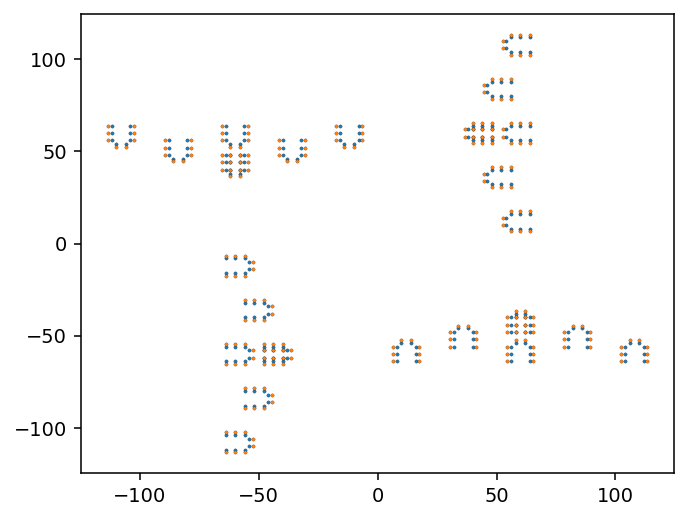

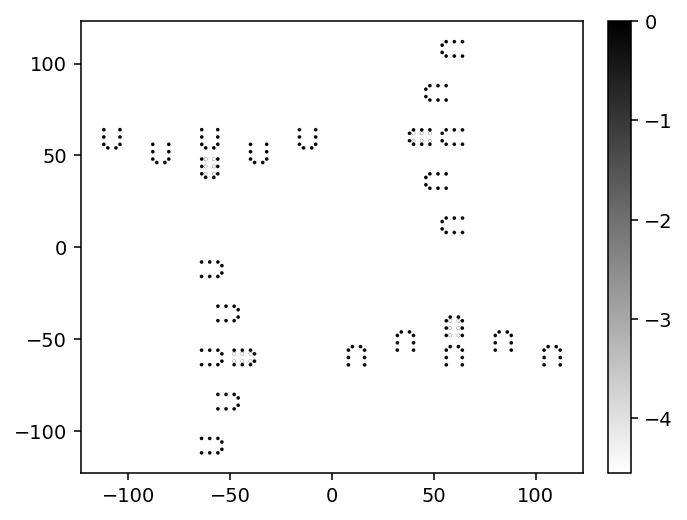

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, edgecolors="black", linewidths=.1)
im=ax.scatter(flowStats['EP_x'], flowStats['EP_z'], s=4*im_scaling, edgecolors="black", linewidths=.1)


fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["y"] - flowStats["EP_y"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)


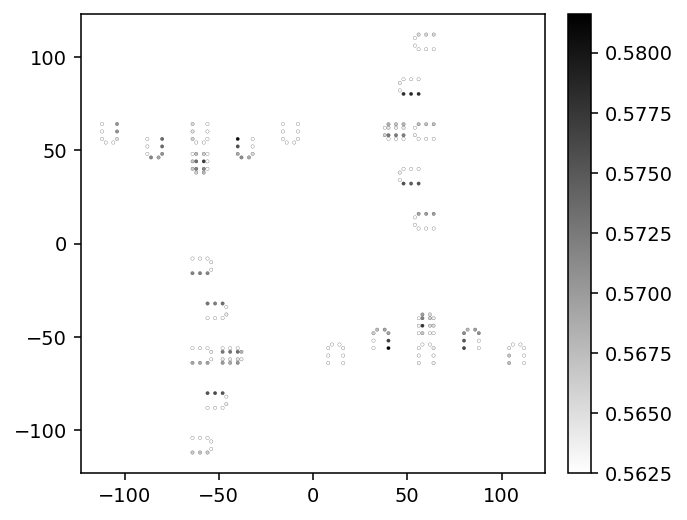

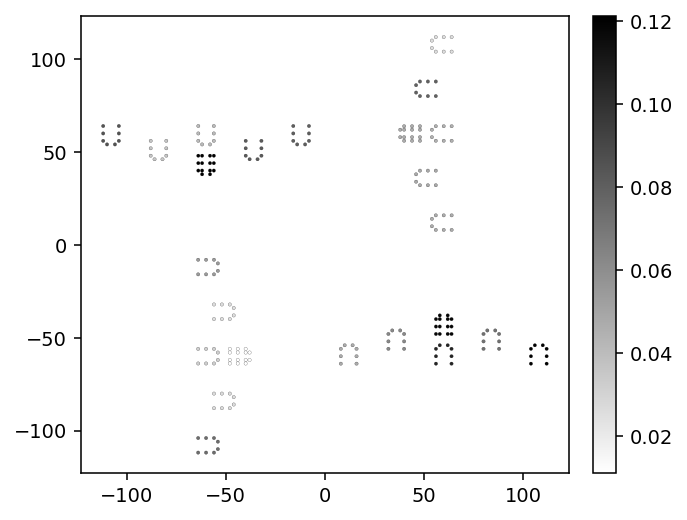

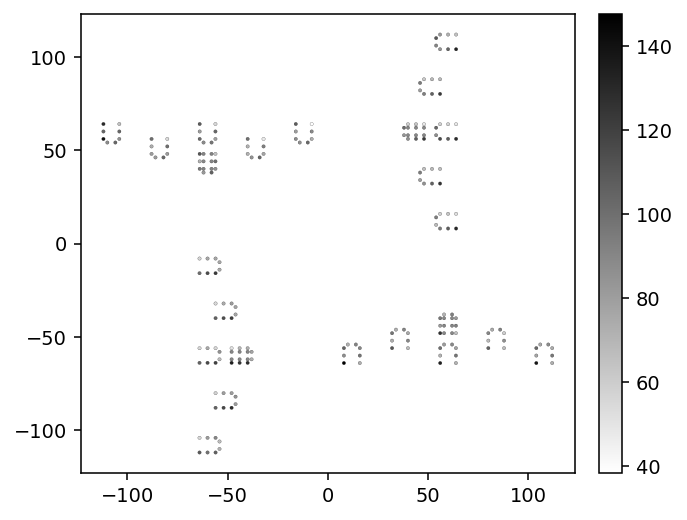

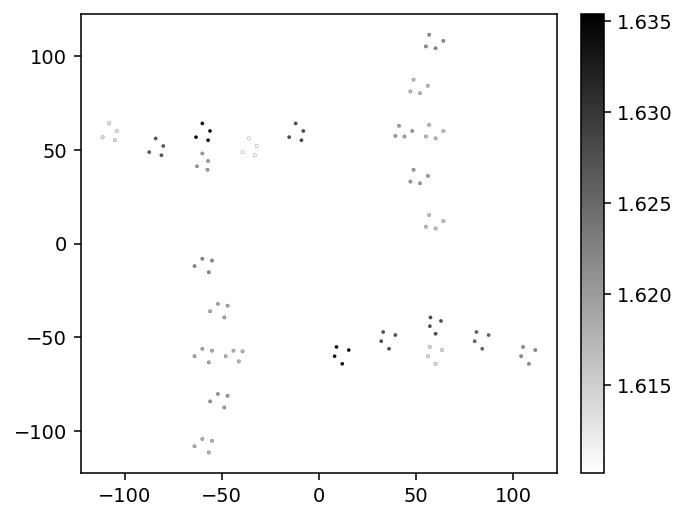

In [ ]:

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["area"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["EPR_vel_orientation"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["EP_vel_orientation"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["EPR_mag"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

In [ ]:
fig = px.scatter(data_frame = flowStats, x = "EPR_mag", y = "mean", color = "roomType", symbol="roomType")
fig.update_xaxes(title_text='2H Wind Speed')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()
 
fig = px.scatter(data_frame = flowStats, x = "EP_normal", y = "mean", color = "EP_shear", symbol = "roomType")
fig.update_xaxes(title_text='Component of Wind Normal to Window')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()

In [ ]:
fig = px.scatter(data_frame = roomVentilation, x = "EPR_mag", y = "mean", color = "roomType", symbol="roomType")
fig.update_xaxes(title_text='2H Wind Speed')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()
 
fig = px.scatter_3d(data_frame = roomVentilation, x = "EP_normal_mag", y = "EP_normal_sum",  z = "mean", color = "roomType", symbol = "roomType")
fig.update_xaxes(title_text='Magnitude/Sum of Window Normal Velocities')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()

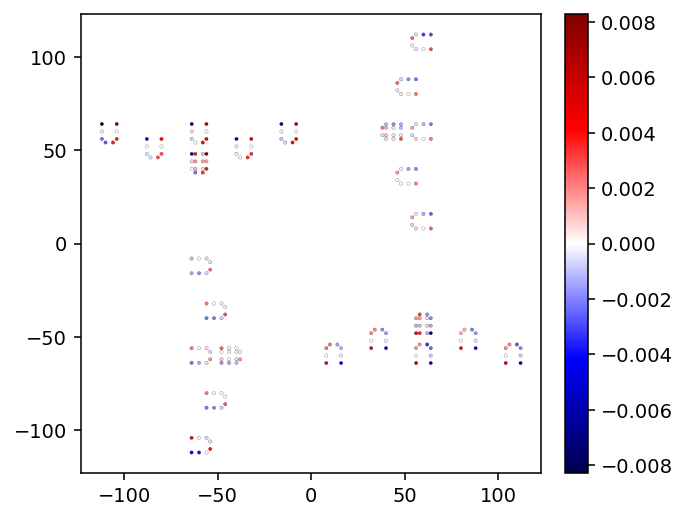

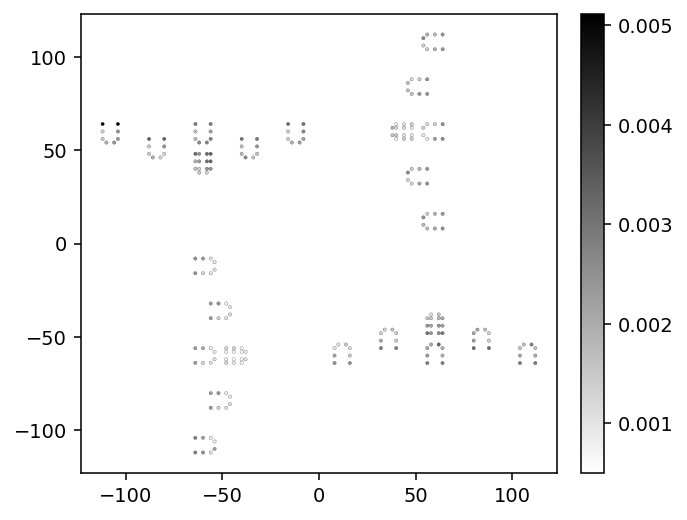

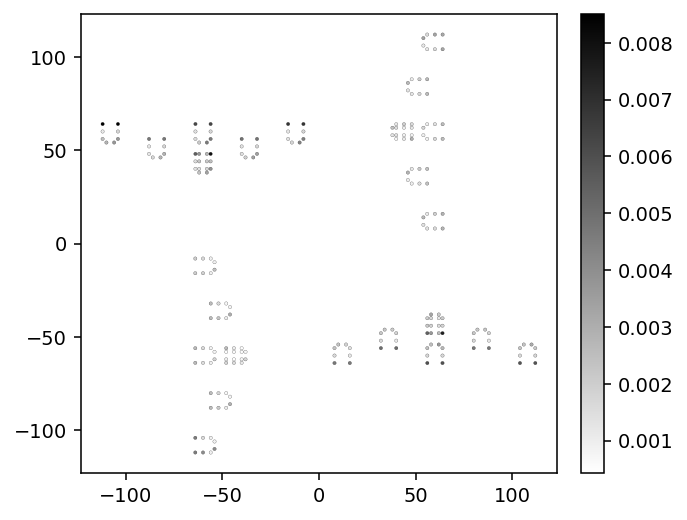

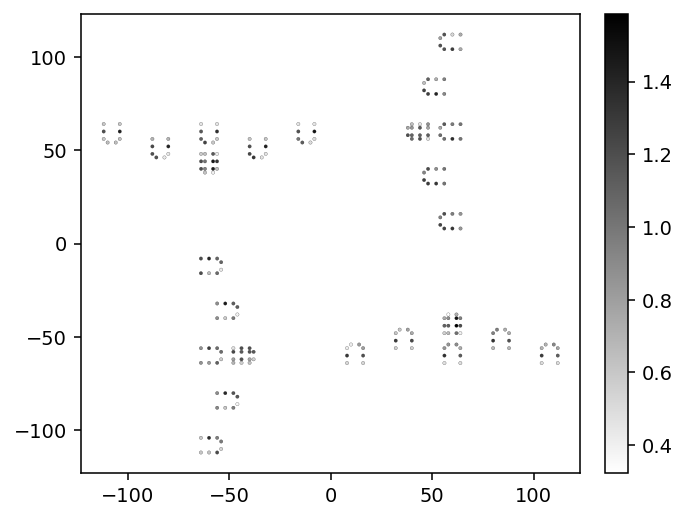

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm=colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"]/flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsOnetInterior', bbox_inches="tight")

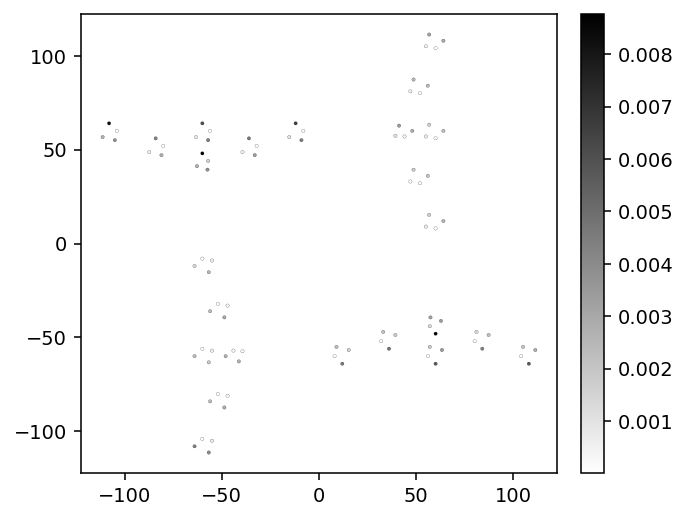

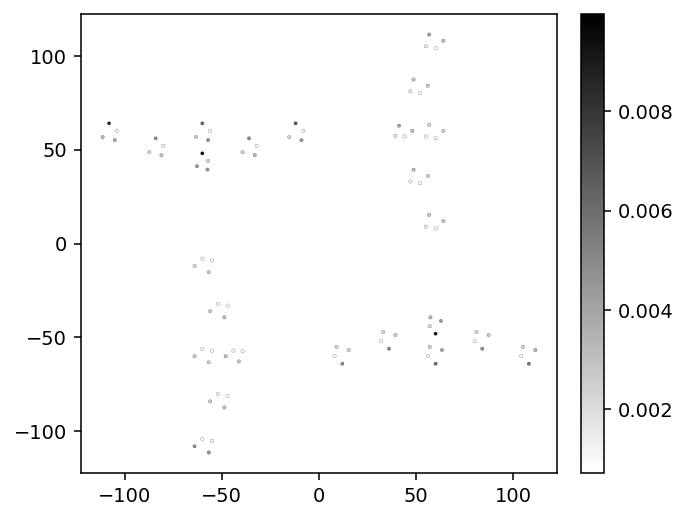

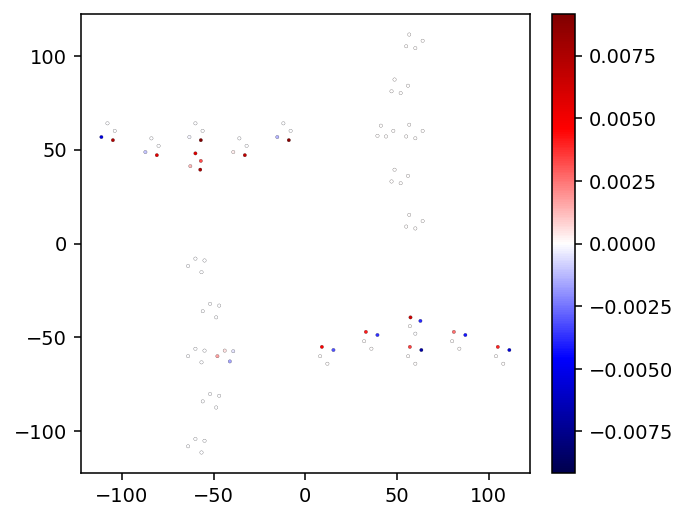

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

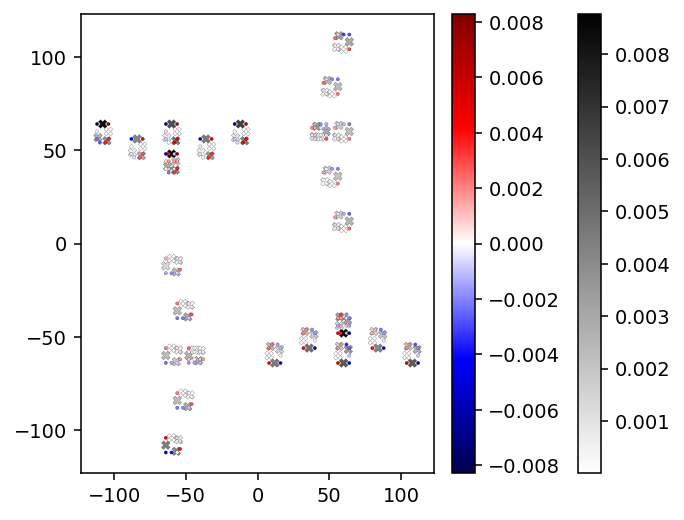

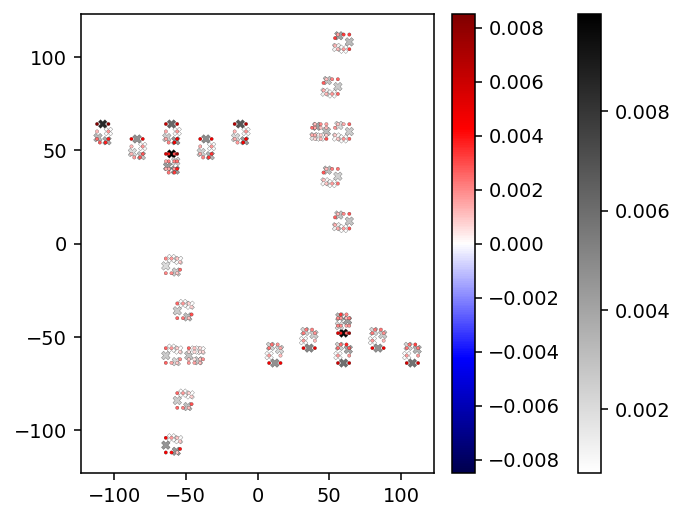

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

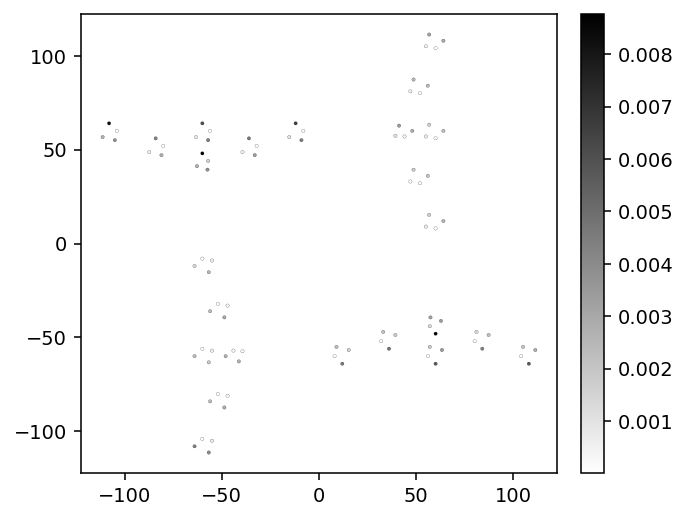

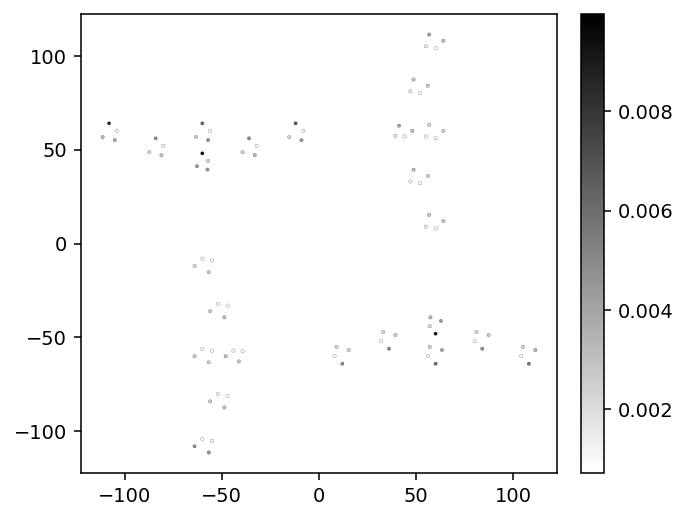

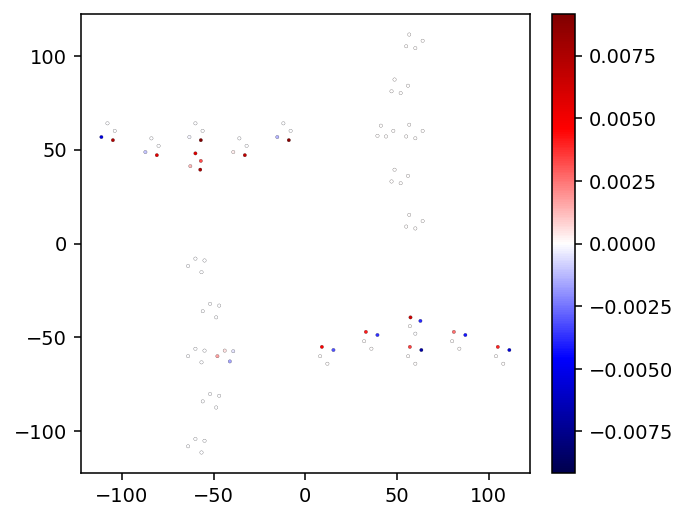

In [ ]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

33.

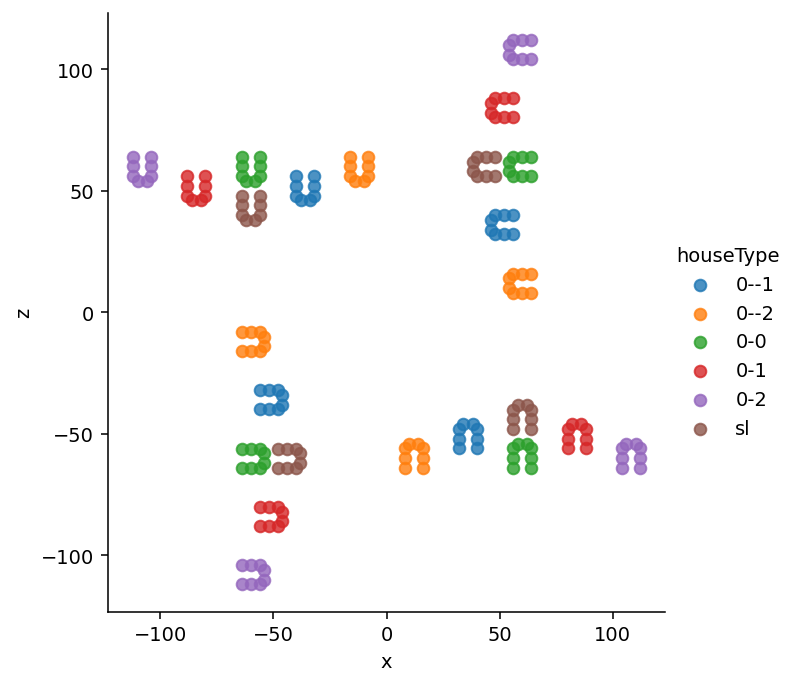

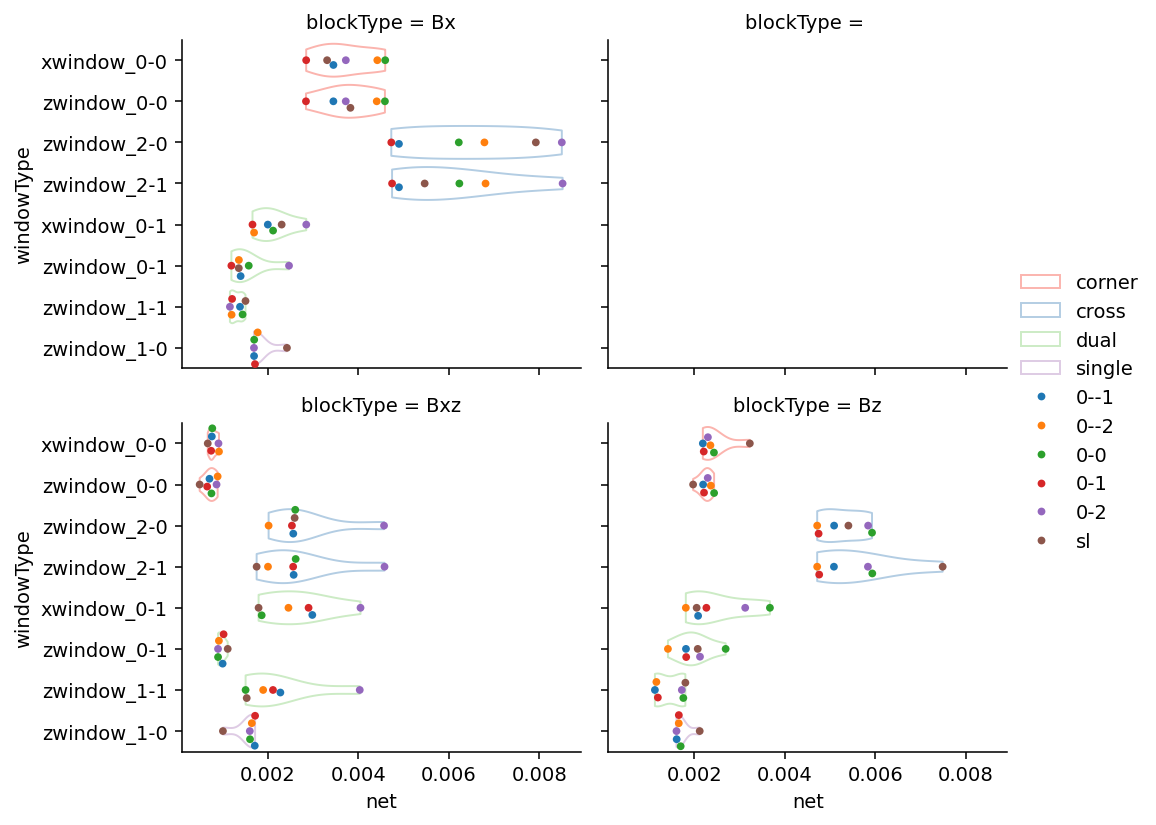

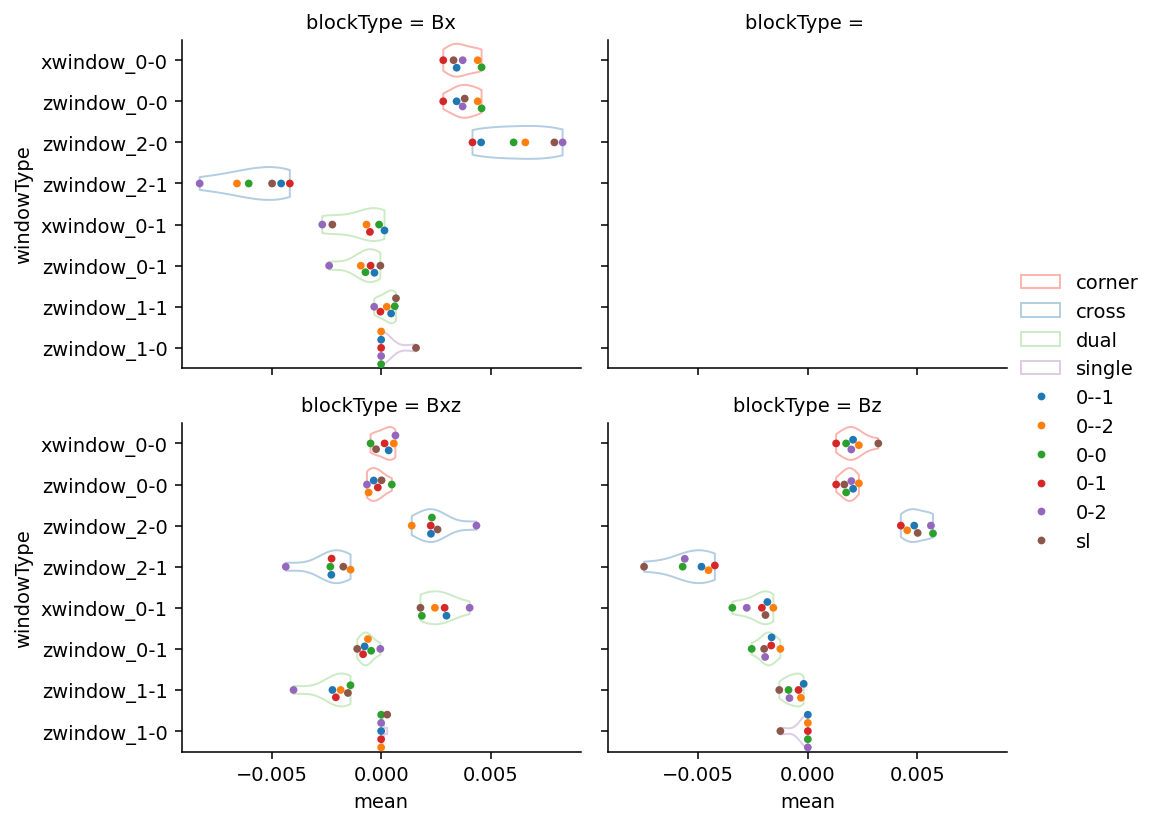

In [ ]:
dfWindows = flowStats.loc[flowStats["openingType"].isin(["xwindow", "zwindow"])]

sns.lmplot(data = dfWindows, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/windowKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "windowType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowViolins', bbox_inches="tight")

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowViolins', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the s

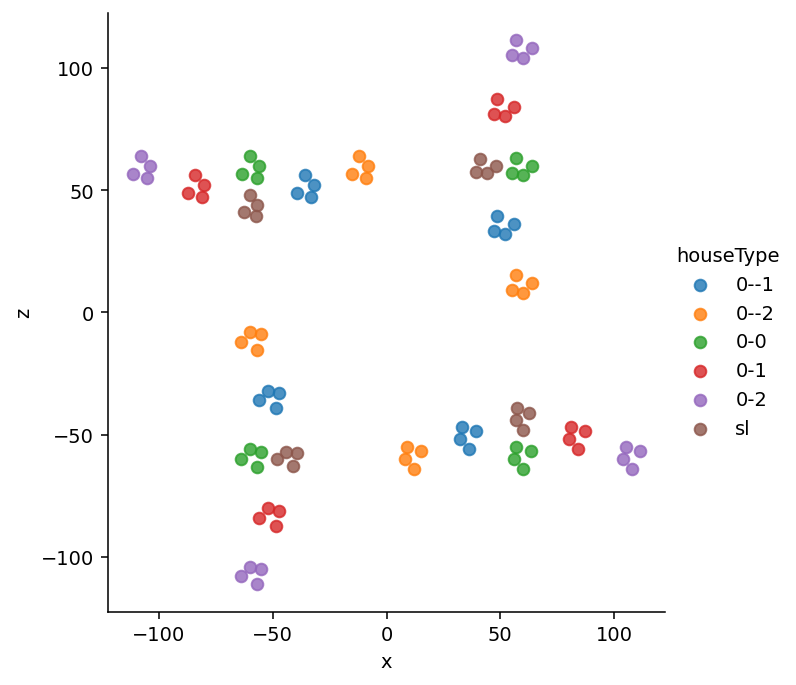

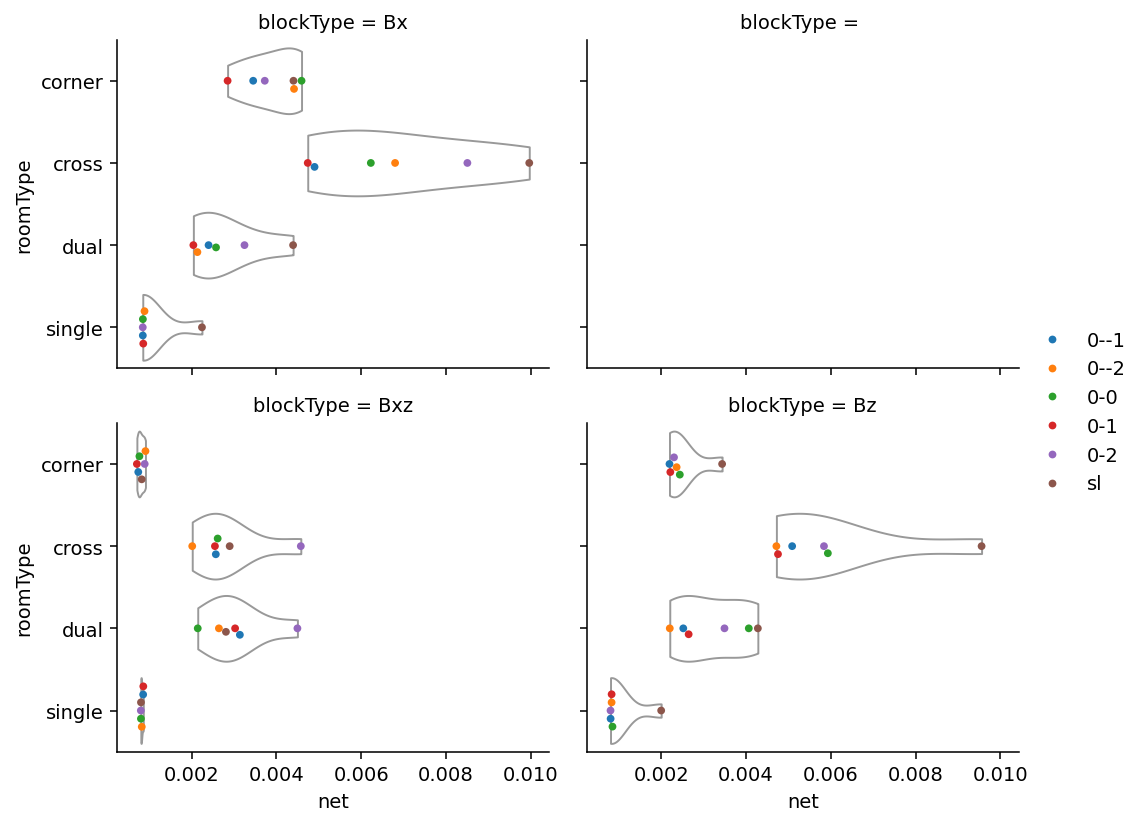

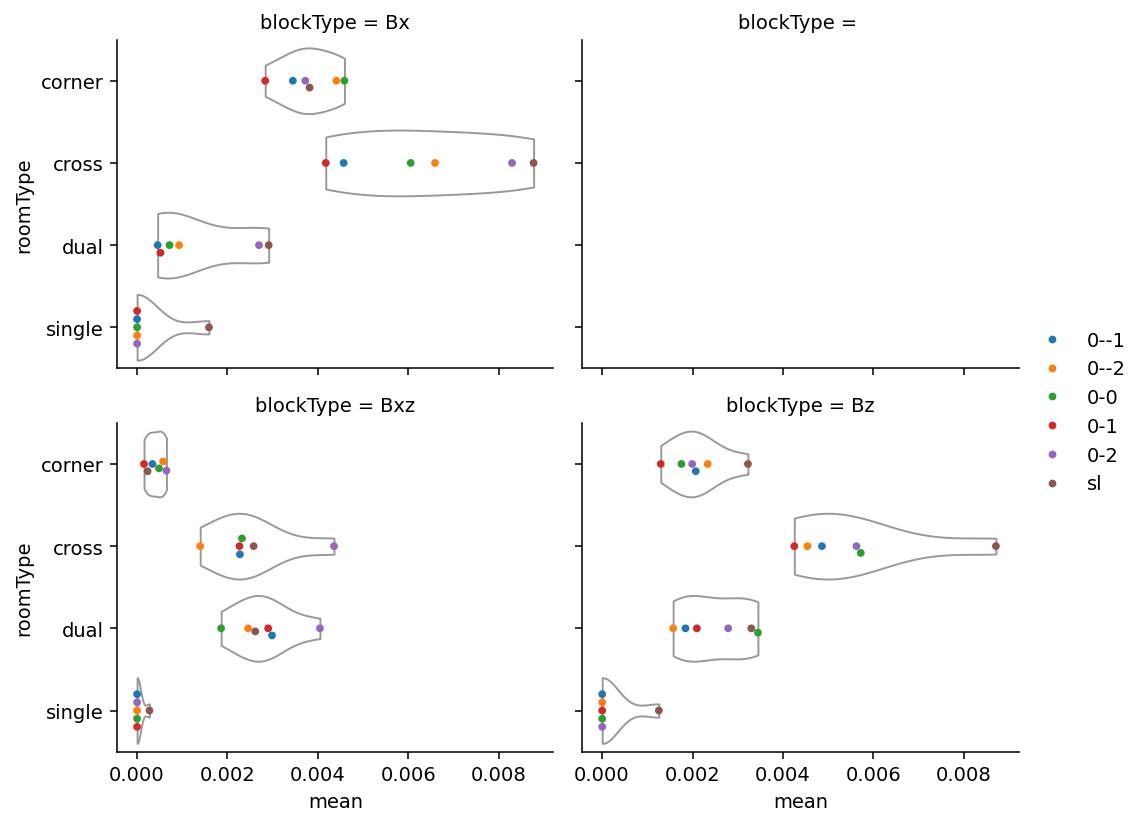

In [ ]:
sns.lmplot(data = roomVentilation, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/roomKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRoomViolins', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRoomViolins', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.



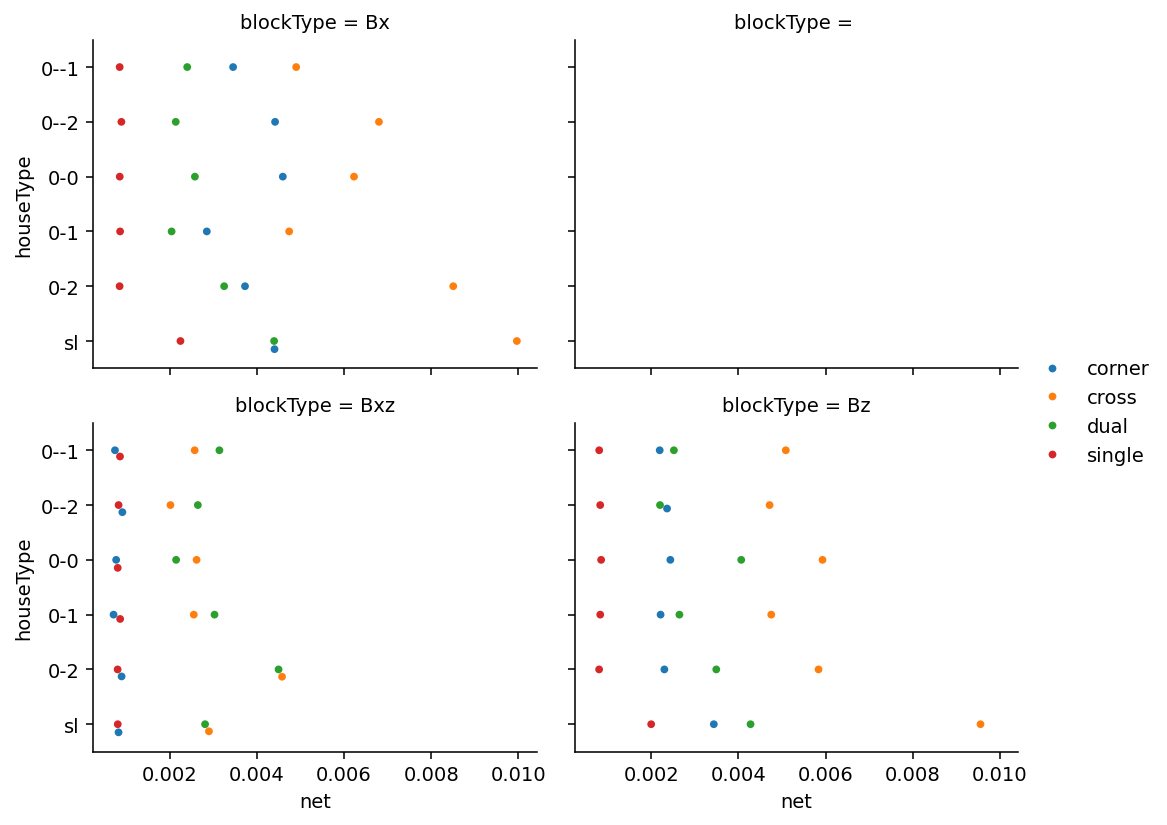

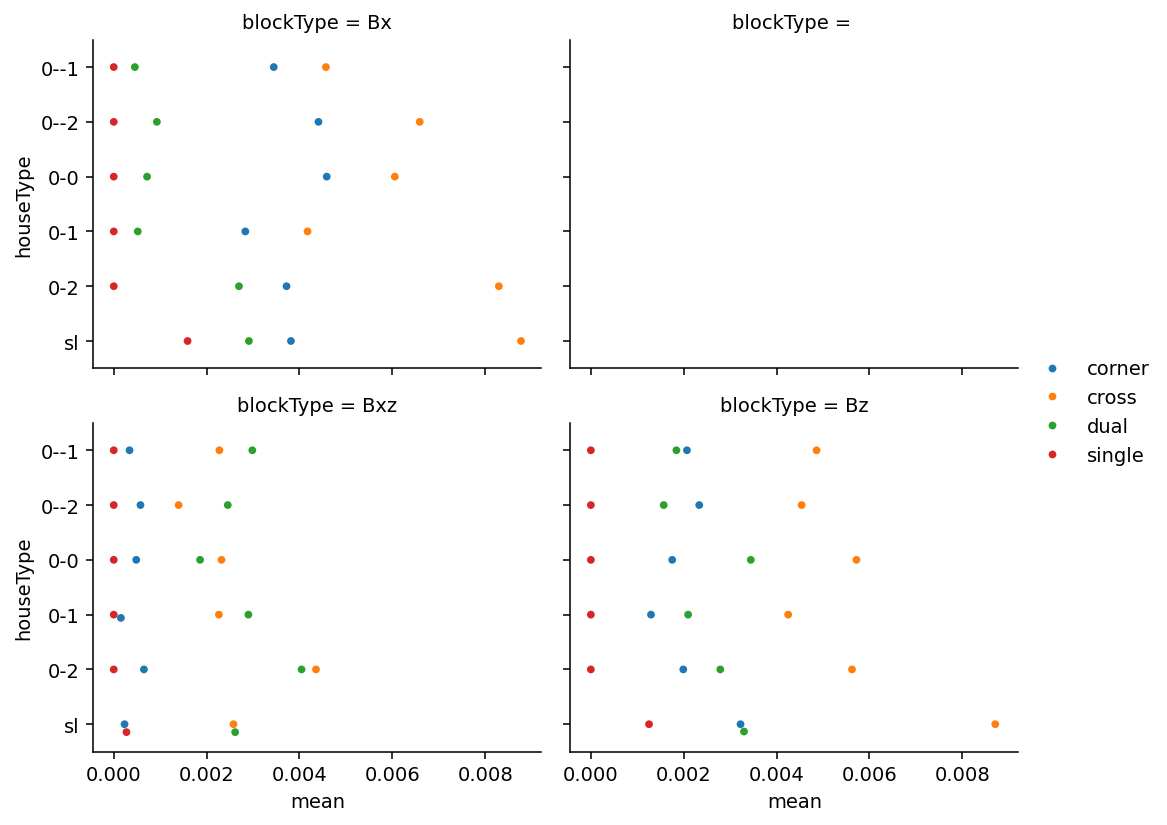

In [ ]:
g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "net", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netHouseByRoom', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "mean", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanHouseByRoom', bbox_inches="tight")

## Convergence

In [ ]:
data = probes.statistics(
    names = [name for name in probes.probe_names if "door" not in name and "room" not in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [],
    parrallel=False
    )

processing data took 2 seconds


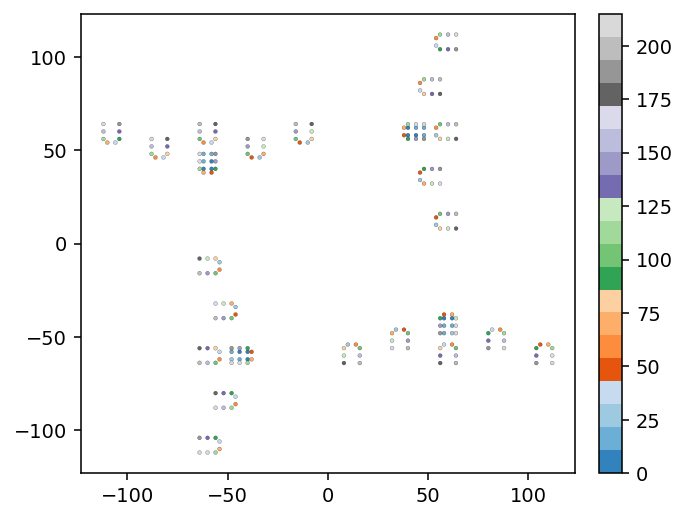

In [ ]:
xPlot = data.index.values
yPlot = np.arange(len(data.keys()))

fig, ax=plt.subplots(1, 1, constrained_layout = True)
im=ax.scatter(flowStats.loc[data.keys(), 'x'], flowStats.loc[data.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/dataMap', bbox_inches="tight")

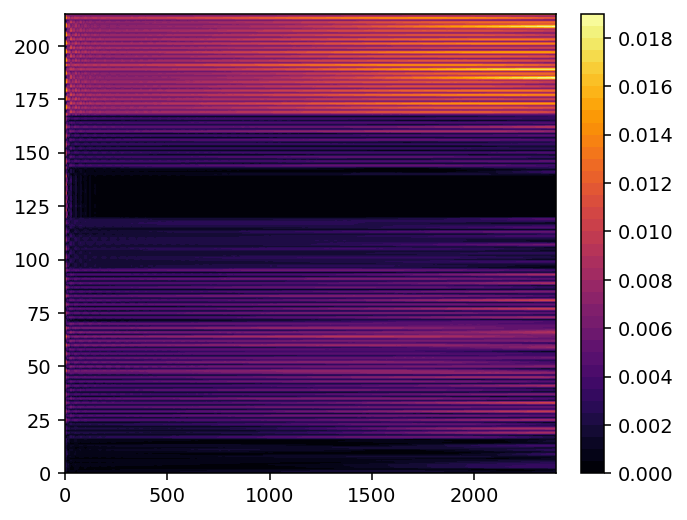

In [ ]:
dataCumMean = probePost.cumulative_mean(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataCumMean.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)
# ax.set_yticks(yPlot)
# ax.set_yticklabels(dataCumMean.keys())

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourCumMean', bbox_inches="tight")

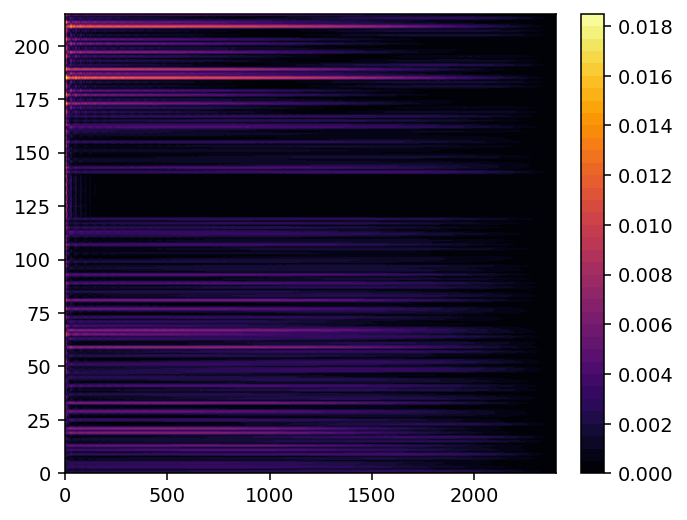

In [ ]:
dataConv = probePost.convergence(dataCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataConv.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConv', bbox_inches="tight")

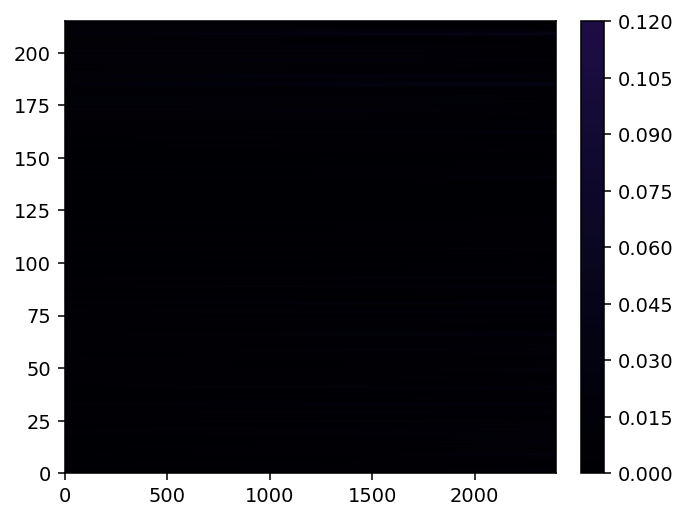

In [ ]:
dataRevCumMean = probePost.reverse(data)
dataRevCumMean = probePost.cumulative_mean(dataRevCumMean)
dataRevCumMean = probePost.reverse(dataRevCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataRevCumMean.abs().T, cmap = "inferno", levels=40, vmax = 1)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourRevCumMean', bbox_inches="tight")

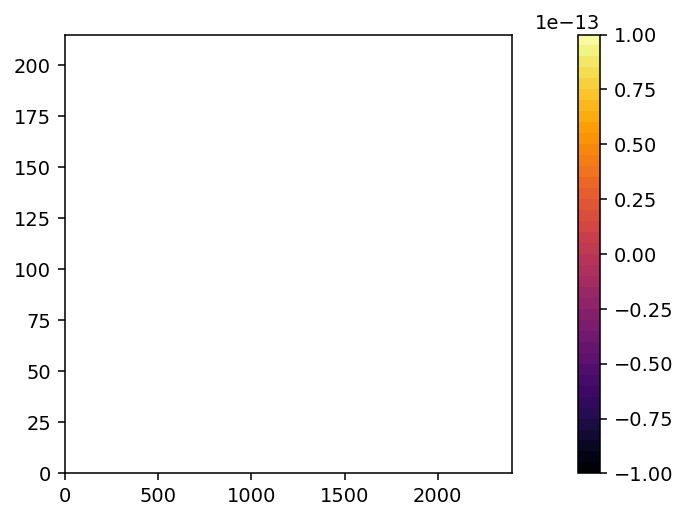

In [ ]:
@utils.no_kwargs
@utils.dict_apply
def sma(df): 
    return df.rolling(8000).mean()
    
dataSMA = sma(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataSMA.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourSMA', bbox_inches="tight")